In [79]:
import importlib

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from Utils import paths
from Utils import transformation_utils as t_utils
from Utils import plot_utils
from Utils import common_functions
importlib.reload(plot_utils)
importlib.reload(common_functions)

<module 'Utils.common_functions' from 'C:\\Users\\jllav\\IdeaProjects\\TFM\\Utils\\common_functions.py'>

In [59]:
fhr = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/fhr.pickle")
uc = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/uc.pickle")
y = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/y.pickle")

fhr.shape, uc.shape, y.shape

((552, 21620), (552, 21620), (552,))

In [3]:
before_dismissed = [1104, 1119, 1134, 1149, 1155, 1158, 1186, 1188, 1258, 1292, 1322,
                    1327, 1451, 1477, 1482, 2003]

15 5 533 (552, 3600) (19, 3600) True
15 10 506 (552, 3600) (46, 3600) True
15 20 427 (552, 3600) (125, 3600) True
15 30 349 (552, 3600) (203, 3600) True
20 5 535 (552, 4800) (17, 4800) True
20 10 501 (552, 4800) (51, 4800) True
20 20 412 (552, 4800) (140, 4800) True
20 30 328 (552, 4800) (224, 4800) True
30 5 539 (552, 7200) (13, 7200) True
30 10 499 (552, 7200) (53, 7200) True
30 20 401 (552, 7200) (151, 7200) True
30 30 295 (552, 7200) (257, 7200) True


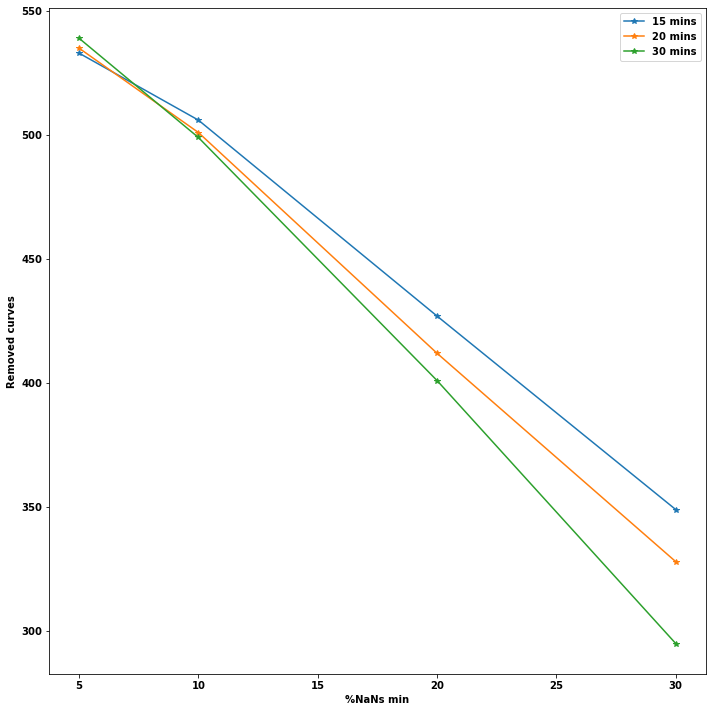

In [58]:
# mins_cut = 30
# nan_percentage_threshold = 30

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nan_percentage_thresholds = [5, 10, 20, 30]
for mins_cut in [15, 20, 30]:
    results = []
    for nan_percentage_threshold in nan_percentage_thresholds:
        cut_fhr = fhr.copy().iloc[:, -mins_cut * 60 * 4:]
        fhr_nans_percent = (cut_fhr.isna().sum(axis=1) / cut_fhr.shape[1] * 100)
        fhr_now_dismissed = fhr_nans_percent.index[fhr_nans_percent > nan_percentage_threshold].to_list()

        cut_uc = uc.copy().iloc[:, -mins_cut * 60 * 4:]
        uc_nans_percent = (cut_uc.isna().sum(axis=1) / cut_fhr.shape[1] * 100)
        uc_now_dismissed = uc_nans_percent.index[uc_nans_percent > nan_percentage_threshold].to_list()

        removed = list(set(fhr_now_dismissed).union(set(uc_now_dismissed)))

        check_list = [x for x in before_dismissed if (x not in fhr_now_dismissed) and (x not in uc_now_dismissed)]
        print(
            f"{mins_cut} {nan_percentage_threshold} {len(removed)} {cut_fhr.shape} {cut_fhr.drop(removed).shape} {len(check_list) == 0}")
        results.append(len(removed))
    ax.plot(nan_percentage_thresholds, results, '*-', label=f"{mins_cut} mins")
ax.legend()
ax.set_ylabel('Removed curves')
ax.set_xlabel('%NaNs min')
# ax.set_yscale('log')
fig.tight_layout()
plt.savefig(f"filtered_curves.pdf")

In [72]:
clean_fhr, clean_uc, y_clean = common_functions.filter_patterns(fhr, uc, y, mins_cut=30, nan_percentage_threshold=30)

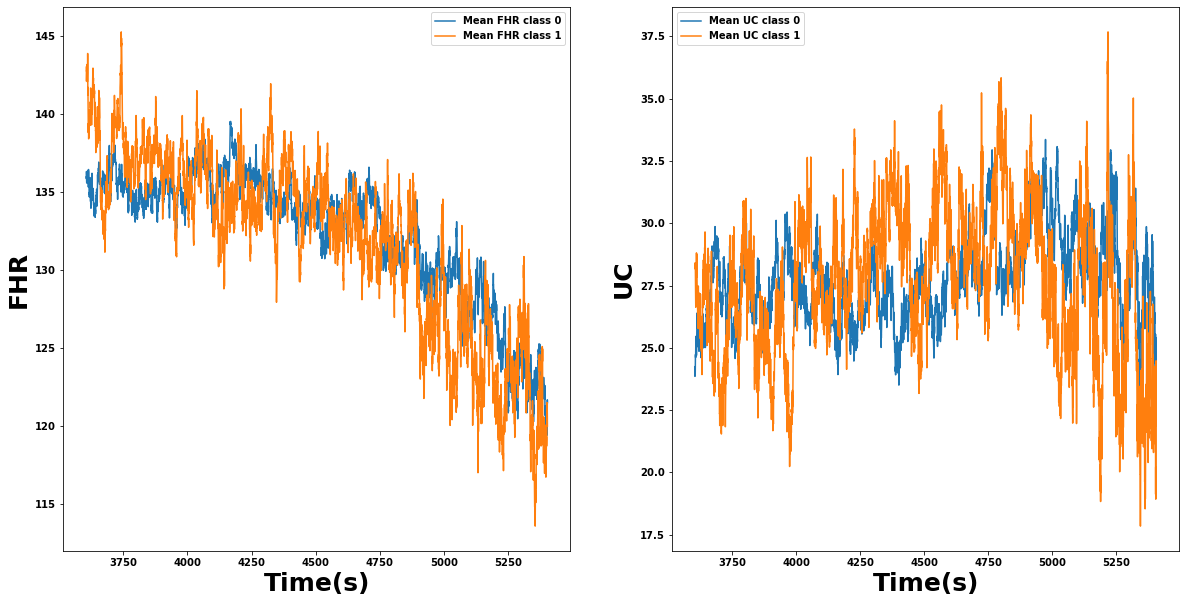

In [73]:
plot_utils.plot_fhr_uc(clean_fhr, clean_uc, y_clean)

In [34]:
cc_data = dict()
lags = t_utils.calc_lags(minutes=5)

for (idx_fhr, fhr_row), (idx_uc, uc_row) in tqdm(zip(clean_fhr.copy().iterrows(), clean_uc.copy().iterrows()), total=len(clean_uc)):
    fhr_signal = pd.Series(fhr_row.values)
    uc_signal = pd.Series(uc_row.values)

    cc_data[idx_fhr] = joblib.Parallel(n_jobs=8)(
        joblib.delayed(t_utils.cc)(fhr_signal, uc_signal, lag, 1000) for lag in lags
    )
cc_df = pd.DataFrame(cc_data).T
cc_df.columns = lags
cc_df

  0%|          | 0/257 [00:00<?, ?it/s]

,-1199,-1198,-1197,-1196,-1195,-1194,-1193,-1192,-1191,-1190,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
1008,-0.027218,-0.027350,-0.027450,-0.027376,-0.027243,-0.026799,-0.026282,-0.025606,-0.024953,-0.024232,...,-0.447103,-0.446072,-0.444980,-0.444201,-0.443296,-0.442431,-0.441648,-0.440916,-0.440144,-0.439561
1011,-0.031679,-0.032592,-0.033147,-0.033720,-0.033770,-0.033200,-0.031955,-0.030639,-0.029292,-0.027882,...,-0.097333,-0.094022,-0.090596,-0.087206,-0.083688,-0.080219,-0.076717,-0.073410,-0.070142,-0.067485
1012,-0.081252,-0.082587,-0.083860,-0.084978,-0.086131,-0.087201,-0.088620,-0.090377,-0.092559,-0.094490,...,-0.106782,-0.107614,-0.108310,-0.109056,-0.110060,-0.110531,-0.111074,-0.111211,-0.111114,-0.110515
1018,0.147230,0.147562,0.148149,0.149600,0.150158,0.151066,0.151505,0.152044,0.152471,0.152992,...,-0.139580,-0.139952,-0.140761,-0.141679,-0.142533,-0.143845,-0.145525,-0.147182,-0.148347,-0.150240
1020,-0.054537,-0.057466,-0.060471,-0.063406,-0.066573,-0.069506,-0.072400,-0.075397,-0.078185,-0.081130,...,-0.009317,-0.010331,-0.010540,-0.009947,-0.010436,-0.010994,-0.012442,-0.014626,-0.015909,-0.017865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2041,0.112279,0.108199,0.104078,0.099634,0.095342,0.091268,0.087211,0.082954,0.078658,0.074261,...,-0.013257,-0.014824,-0.016330,-0.017793,-0.019227,-0.020628,-0.021961,-0.023201,-0.024357,-0.025430
2042,-0.000738,0.002091,0.004137,0.006256,0.008269,0.009779,0.012041,0.013751,0.016146,0.017815,...,-0.160555,-0.162530,-0.164358,-0.165887,-0.167516,-0.169220,-0.170950,-0.172518,-0.174011,-0.175446
2043,0.123914,0.121661,0.118638,0.115165,0.111689,0.108751,0.105708,0.102952,0.098659,0.095087,...,-0.142478,-0.142444,-0.142659,-0.143299,-0.142871,-0.142850,-0.142266,-0.142161,-0.141798,-0.141701
2044,-0.022633,-0.022700,-0.023905,-0.024814,-0.026762,-0.027899,-0.028969,-0.030256,-0.031453,-0.032864,...,0.041772,0.043260,0.044041,0.045306,0.045280,0.044637,0.043725,0.042310,0.041209,0.040715


In [35]:
bad_idx = cc_df.index[cc_df.isna().sum(axis=1) != 0]
bad_idx

Int64Index([], dtype='int64')

In [39]:
cc_df = cc_df.drop(bad_idx, errors='ignore')
tt = np.array(lags)
cc_df.shape, y.shape

((257, 2399), (257,))

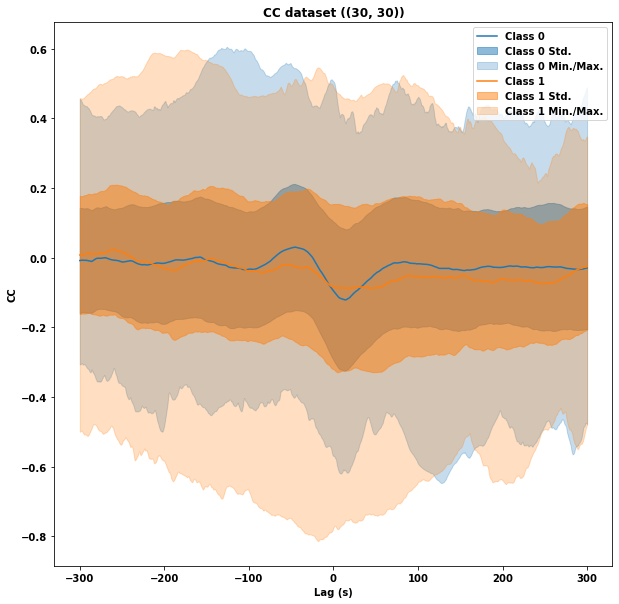

In [78]:
plot_utils.plot_data_desc(tt, cc_df, y_clean, f'CC dataset ({mins_cut, nan_percentage_threshold})', 'CC')

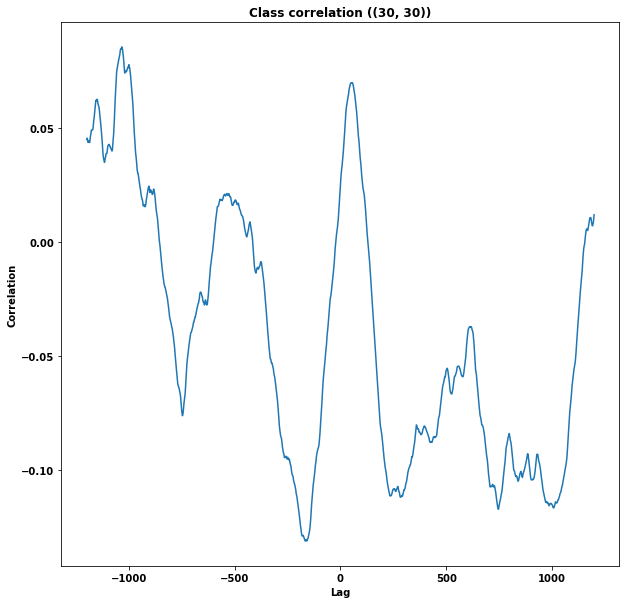

In [77]:
plot_utils.plot_class_correlation(cc_df, y_clean, title=f'Class correlation ({mins_cut, nan_percentage_threshold})')

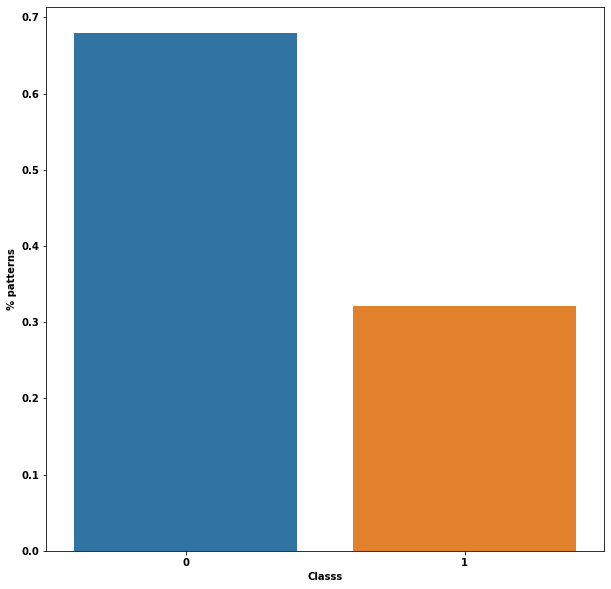

In [76]:
plot_utils.plot_class_proportion(y)

  0%|          | 0/2399 [00:00<?, ?it/s]

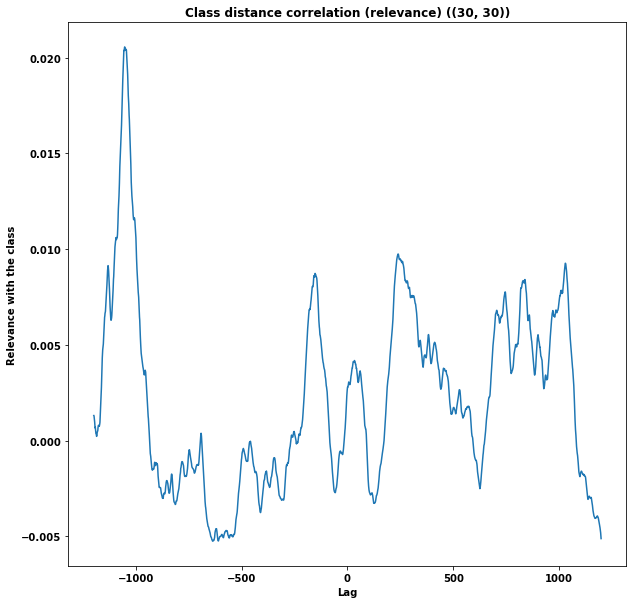

In [80]:
plot_utils.plot_relevance(cc_df, y_clean, title=f'Class distance correlation (relevance) ({mins_cut, nan_percentage_threshold})')